<a href="https://colab.research.google.com/github/ANTRIKSH-GANJOO/pytorch_research/blob/main/WithReg_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import matplotlib.pyplot as plt
import numpy as np

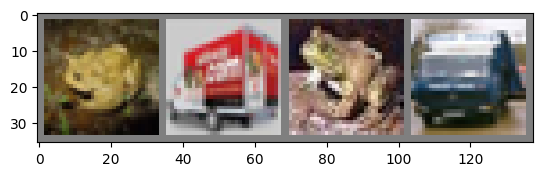

frog  truck frog  truck


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        l1_norm = torch.norm(out,1)
        l2_norm = torch.norm(out,2)
        quotient = l1_norm / l2_norm
        hoyer_norm = quotient ** 2
        reg = hoyer_norm
        out = self.layer1(out)
        l1_norm = torch.norm(out,1)
        l2_norm = torch.norm(out,2)
        quotient = l1_norm / l2_norm
        hoyer_norm = quotient ** 2
        reg += hoyer_norm
        out = self.layer2(out)
        l1_norm = torch.norm(out,1)
        l2_norm = torch.norm(out,2)
        quotient = l1_norm / l2_norm
        hoyer_norm = quotient ** 2
        reg += hoyer_norm
        out = self.layer3(out)
        l1_norm = torch.norm(out,1)
        l2_norm = torch.norm(out,2)
        quotient = l1_norm / l2_norm
        hoyer_norm = quotient ** 2
        reg += hoyer_norm
        out = self.layer4(out)
        l1_norm = torch.norm(out,1)
        l2_norm = torch.norm(out,2)
        quotient = l1_norm / l2_norm
        hoyer_norm = quotient ** 2
        reg += hoyer_norm
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out,reg


def ResNet18():

    return ResNet(ResidualBlock)

my_net = ResNet18()

In [76]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_net.to(device)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inp

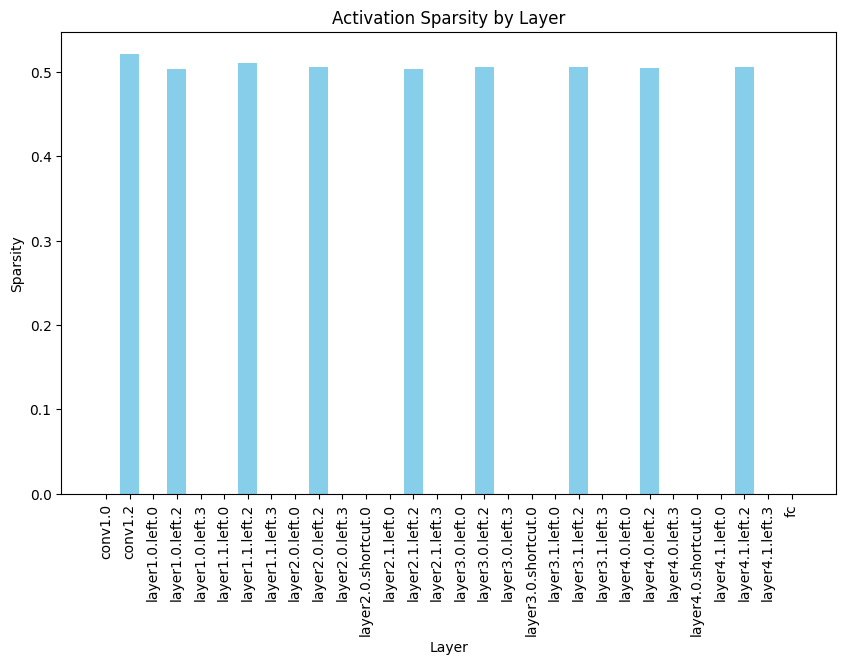

In [79]:
initial_sparsity_values = []

def get_initial_activation_sparsity(name):
    def hook(model, input, output):
        total_elements = output.numel()
        zero_elements = (output == 0).sum().item()
        sparsity = zero_elements / total_elements
        initial_sparsity_values.append((name, sparsity))
    return hook

# Register hooks on the layers
initial_hooks = []
for name, layer in my_net.named_modules():
    if isinstance(layer, (nn.Conv2d, nn.ReLU, nn.Linear)):
        hook = layer.register_forward_hook(get_initial_activation_sparsity(name))
        initial_hooks.append(hook)

with torch.no_grad():
    for batch, _ in testloader:
        batch = batch.to(device)
        output = my_net(batch)
    
        


# Remove hooks after measurement to avoid memory leaks
for hook in initial_hooks:
    hook.remove()

# Initial sparsity values
layer_names, initial_sparsities = zip(*initial_sparsity_values)

plt.figure(figsize=(10, 6))
plt.bar(layer_names, initial_sparsities, color='skyblue')
plt.xlabel('Layer')
plt.ylabel('Sparsity')
plt.title('Activation Sparsity by Layer')
plt.xticks(rotation=90)
# plt.savefig("activation_sparsity_layer_test.pdf")
plt.show()

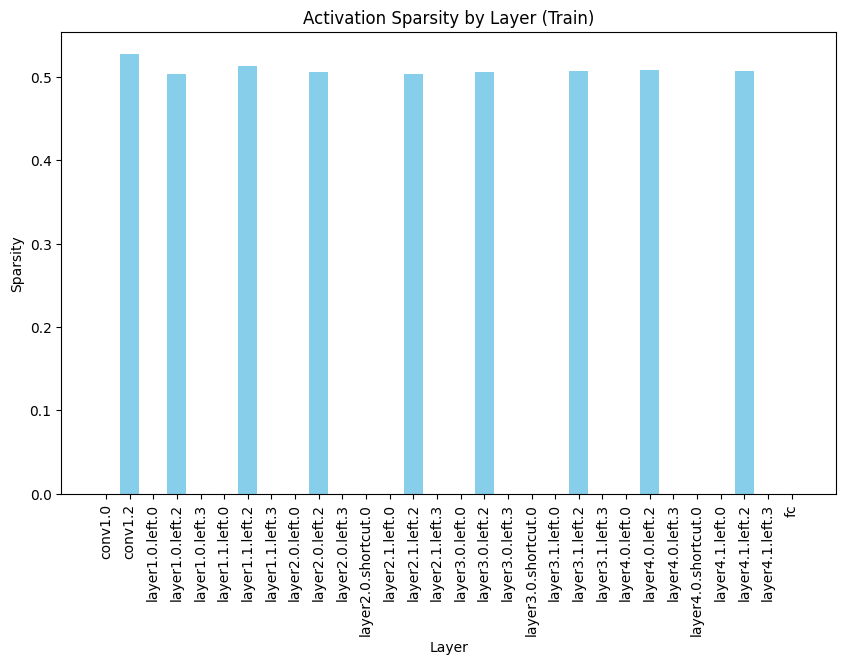

In [80]:
initial_sparsity_values_train = []

def get_initial_activation_sparsity_train(name):
    def hook(model, input, output):
        total_elements = output.numel()
        zero_elements = (output == 0).sum().item()
        sparsity = zero_elements / total_elements
        initial_sparsity_values_train.append((name, sparsity))
    return hook
    
# Register hooks on the layers
initial_train_hooks = []
for name, layer in my_net.named_modules():
    if isinstance(layer, (nn.Conv2d, nn.ReLU, nn.Linear)):
        hook = layer.register_forward_hook(get_initial_activation_sparsity_train(name))
        initial_train_hooks.append(hook)

with torch.no_grad():
    for batch, _ in trainloader:
        batch = batch.to(device)
        output = my_net(batch)
    
        


# Remove hooks after measurement to avoid memory leaks
for hook in initial_train_hooks:
    hook.remove()

# Initial sparsity values
layer_names, initial_sparsities_train = zip(*initial_sparsity_values_train)

plt.figure(figsize=(10, 6))
plt.bar(layer_names, initial_sparsities_train, color='skyblue')
plt.xlabel('Layer')
plt.ylabel('Sparsity')
plt.title('Activation Sparsity by Layer (Train)')
plt.xticks(rotation=90)
plt.savefig("activation_sparsity_layer_train.pdf")
plt.show()

### Define model optimizer and loss function 

In [81]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_net.parameters(), lr=0.005, momentum=0.9)

#### Load saved model (pre-trained)

In [65]:
# Instantiate the model
my_net = ResNet18()

# Load the weights
my_net.load_state_dict(torch.load('resnet18_cifar10_train_50+50_ep_weights.pth', map_location=device)) # Change file path
my_net.to(device)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inp

### Train network and check accuracy

In [82]:
# Training the Neural Network
train_acc_list = []
epoch_loss_list = []
total = 0.0
correct = 0.0
alpha_reg = 1e-7
epochs = 100
for epoch in range(epochs):  # loop over the dataset multiple times

    run_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) # pushing to GPU

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs, reg = my_net(inputs)
        loss = criterion(outputs, labels)
        # c = loss + (alpha_reg*reg)
        # c.backward()
        loss.backward()
        optimizer.step()

        # print statistics
        #running_loss += c.item()
        # run_loss += c.item() * inputs.size(0)
        run_loss += loss.item() * inputs.size(0)

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = run_loss / len(trainloader.dataset)
    epoch_loss_list.append(epoch_loss)
    train_acc = 100 * correct / total
    train_acc_list.append(train_acc)
    # epoch_acc = np.mean(train_acc_list[-12500:])
    print(f'Epoch {epoch} completed, Accuracy: {train_acc}')


print('Finished Training')

Epoch 0 completed, Accuracy: 41.202
Epoch 1 completed, Accuracy: 53.922
Epoch 2 completed, Accuracy: 61.513333333333335
Epoch 3 completed, Accuracy: 66.742
Epoch 4 completed, Accuracy: 70.6332
Epoch 5 completed, Accuracy: 73.791
Epoch 6 completed, Accuracy: 76.51028571428571
Epoch 7 completed, Accuracy: 78.81625
Epoch 8 completed, Accuracy: 80.79422222222222
Epoch 9 completed, Accuracy: 82.4892
Epoch 10 completed, Accuracy: 83.94090909090909
Epoch 11 completed, Accuracy: 85.18933333333334
Epoch 12 completed, Accuracy: 86.26446153846153
Epoch 13 completed, Accuracy: 87.216
Epoch 14 completed, Accuracy: 88.04053333333333
Epoch 15 completed, Accuracy: 88.770625
Epoch 16 completed, Accuracy: 89.41682352941176
Epoch 17 completed, Accuracy: 89.99566666666666
Epoch 18 completed, Accuracy: 90.51
Epoch 19 completed, Accuracy: 90.9794
Epoch 20 completed, Accuracy: 91.40704761904762
Epoch 21 completed, Accuracy: 91.79645454545455
Epoch 22 completed, Accuracy: 92.1524347826087
Epoch 23 completed, 

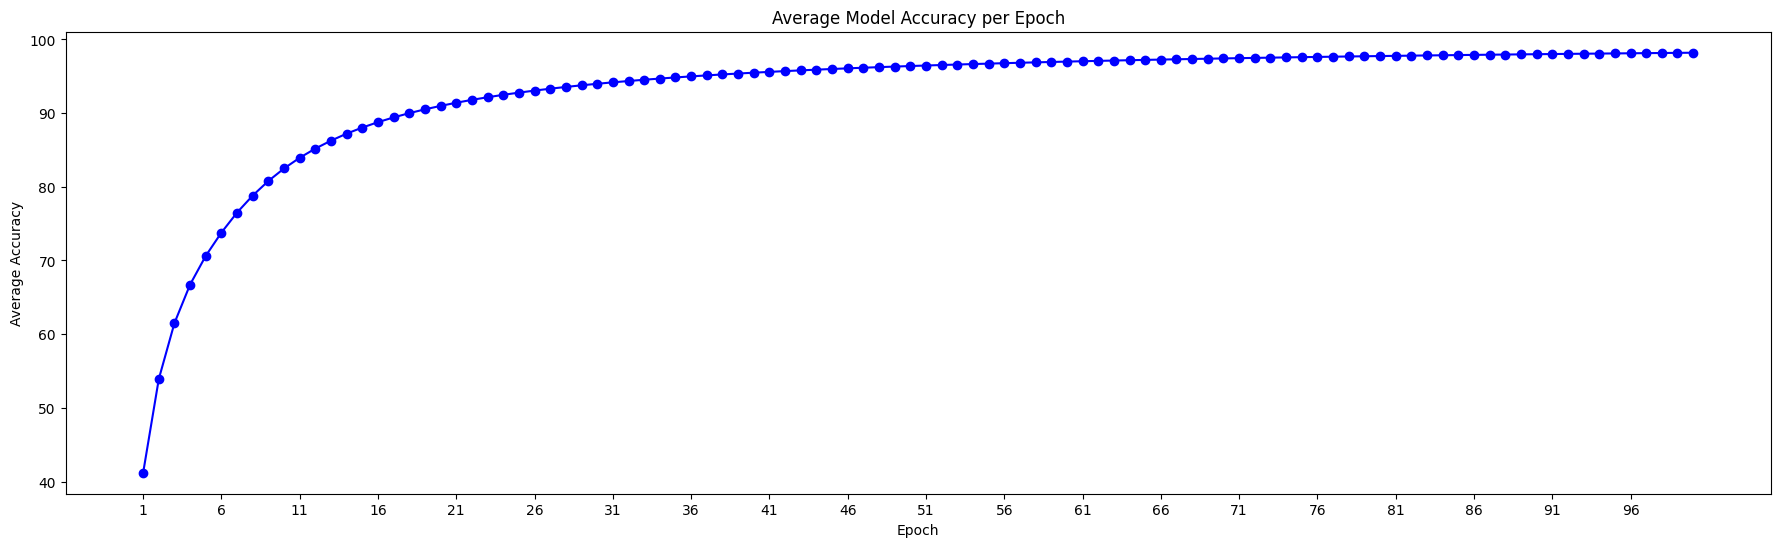

In [87]:
import matplotlib.pyplot as plt

# Number of batches per epoch
batches_per_epoch = 1

# Calculate the number of epochs
num_epochs = len(train_acc_list) // batches_per_epoch

# Calculate average accuracy per epoch
average_acc_per_epoch = [np.mean(train_acc_list[i * batches_per_epoch:(i + 1) * batches_per_epoch]) for i in range(num_epochs)]

# Epoch numbers
epochs = range(1, num_epochs + 1)

# Plotting
plt.figure(figsize=(22, 6))
plt.plot(epochs, average_acc_per_epoch, marker='o', linestyle='-', color='b')
plt.title('Average Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
# plt.grid(True)
plt.xticks(np.arange(min(epochs), max(epochs)+1, 5))
plt.savefig('resnet18_cifar10_accuracy_train_50ep_final.pdf')
plt.show()

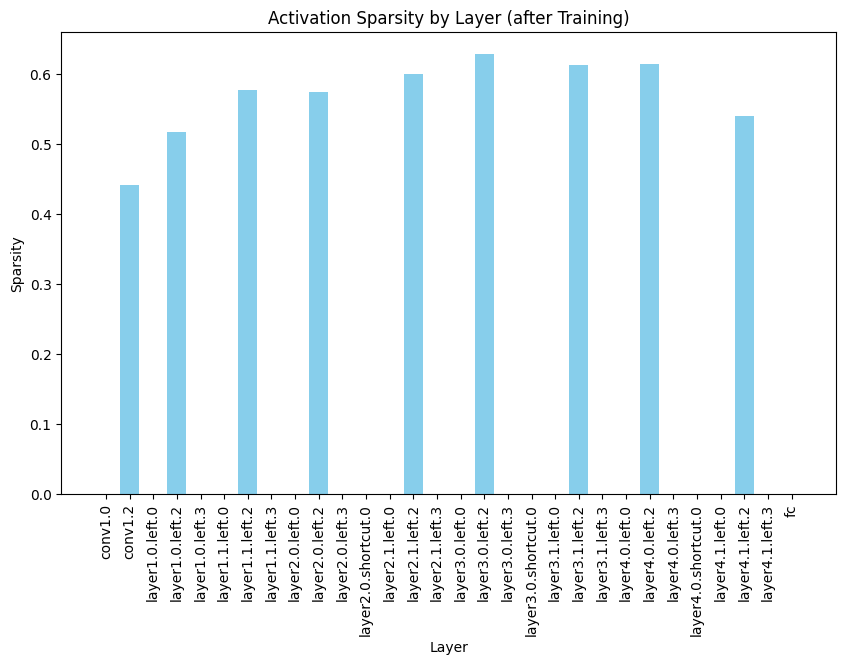

In [89]:
after_train_sparsity_values = []

def get_activation_sparsity_after_training(name):
    def hook(model, input, output):
        total_elements = output.numel()
        zero_elements = (output == 0).sum().item()
        sparsity = zero_elements / total_elements
        after_train_sparsity_values.append((name, sparsity))
    return hook

# Register hooks on the layers
initial_hooks = []
for name, layer in my_net.named_modules():
    if isinstance(layer, (nn.Conv2d, nn.ReLU, nn.Linear)):
        hook = layer.register_forward_hook(get_activation_sparsity_after_training(name))
        initial_hooks.append(hook)

with torch.no_grad():
    for batch, _ in testloader:
        batch = batch.to(device)
        output = my_net(batch)
    
        
# Remove hooks after measurement to avoid memory leaks
for hook in initial_hooks:
    hook.remove()

# Initial sparsity values
layer_names, after_train_sparsities = zip(*after_train_sparsity_values)

plt.figure(figsize=(10, 6))
plt.bar(layer_names, after_train_sparsities, color='skyblue')
plt.xlabel('Layer')
plt.ylabel('Sparsity')
plt.title('Activation Sparsity by Layer (after Training)')
plt.xticks(rotation=90)
plt.savefig("activation_sparsity_layer_testset_after_training.pdf")
plt.show()

#### Save trained model if accuracy is good

In [90]:
# Save the model weights
torch.save(my_net.state_dict(), 'resnet18_cifar10_train_100_ep_weights.pth')

### Train model with regularization

In [92]:
# Training the Neural Network
# train_acc_list = []
# epoch_loss_list = []
total = 0.0
correct = 0.0
alpha_reg = 1e-7
epochs = 10
for epoch in range(epochs):  # loop over the dataset multiple times

    run_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) # pushing to GPU

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs, reg = my_net(inputs)
        loss = criterion(outputs, labels)
        c = loss + (alpha_reg*reg)
        c.backward()
        # loss.backward()
        optimizer.step()

        # print statistics
        #running_loss += c.item()
        run_loss += c.item() * inputs.size(0)
        # run_loss += loss.item() * inputs.size(0)

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = run_loss / len(trainloader.dataset)
    epoch_loss_list.append(epoch_loss)
    train_acc = 100 * correct / total
    train_acc_list.append(train_acc)
    # epoch_acc = np.mean(train_acc_list[-12500:])
    print(f'Epoch {epoch} completed, Accuracy: {train_acc}')


print('Finished Training')

Epoch 0 completed, Accuracy: 96.148
Epoch 1 completed, Accuracy: 96.389
Epoch 2 completed, Accuracy: 96.868
Epoch 3 completed, Accuracy: 97.14
Epoch 4 completed, Accuracy: 97.4288
Epoch 5 completed, Accuracy: 97.67066666666666
Epoch 6 completed, Accuracy: 97.85771428571428
Epoch 7 completed, Accuracy: 98.03575
Epoch 8 completed, Accuracy: 98.18066666666667
Epoch 9 completed, Accuracy: 98.31
Finished Training


### Measure sparsity after regularization

In [103]:
# Measure sparsity after training

# List to store post-training sparsity values
post_reg_sparsity_values = []

def get_post_reg_activation_sparsity(name):
    def hook(model, input, output):
        total_elements = output.numel()
        zero_elements = (output == 0).sum().item()
        sparsity = zero_elements / total_elements
        post_reg_sparsity_values.append((name, sparsity))
    return hook

# Register hooks on the layers
post_reg_hooks = []
for name, layer in my_net.named_modules():
    if isinstance(layer, (nn.Conv2d, nn.ReLU, nn.Linear)):
        hook = layer.register_forward_hook(get_post_reg_activation_sparsity(name))
        post_reg_hooks.append(hook)

# Run a forward pass to measure post-training sparsity
# with torch.no_grad():
#     _ = my_net(inputs)
with torch.no_grad():
    for batch, _ in testloader:
        batch = batch.to(device)
        output = my_net(batch)

# Remove hooks after measurement to avoid memory leaks
for hook in post_reg_hooks:
    hook.remove()

# Post-training sparsity values
layer_names, post_reg_sparsities = zip(*post_reg_sparsity_values)


### Check sparsity using plots

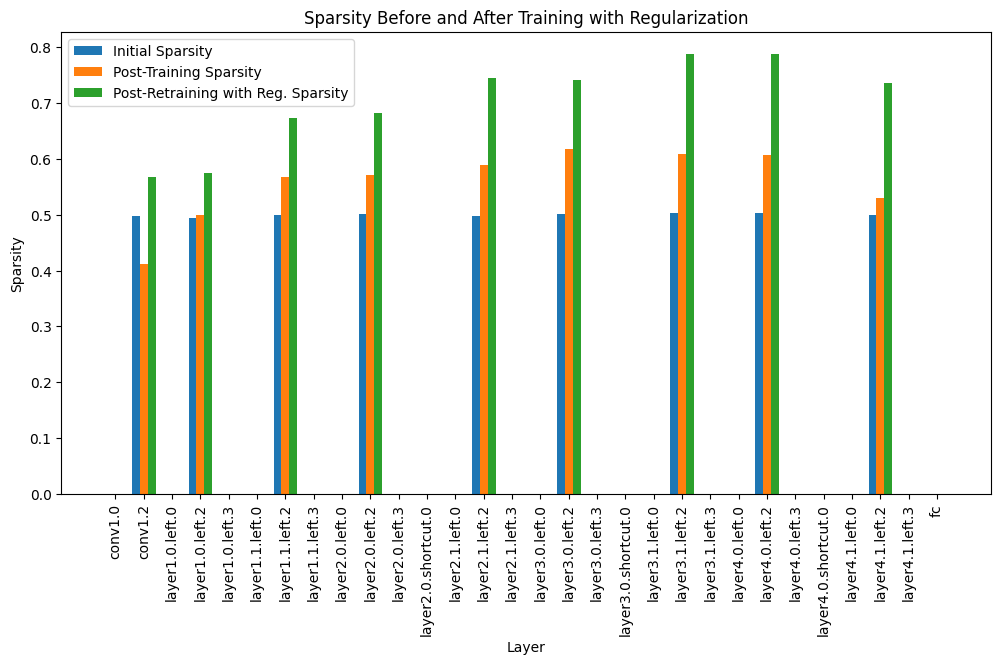

In [113]:
# Plot initial and post-training sparsity values
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(layer_names[:30]))
width = 0.28

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width, initial_sparsities[:30], width, label='Initial Sparsity')
bars2 = ax.bar(x, after_train_sparsities[:30], width, label='Post-Training Sparsity')
bars3 = ax.bar(x + width, post_reg_sparsities[:30], width, label='Post-Retraining with Reg. Sparsity')

ax.set_xlabel('Layer')
ax.set_ylabel('Sparsity')
ax.set_title('Sparsity Before and After Training with Regularization')
ax.set_xticks(np.arange(min(x),max(x)+1, 1))
ax.set_xticklabels(layer_names[:30], rotation=90)
ax.legend()

plt.savefig("sparsity_comparison.pdf")

plt.show()


### Test the accuracy on test dataset

In [107]:
total = 0.0
correct = 0.0
test_loss = 0.0
test_acc_list = []
my_net.eval()

with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) # pushing to GPU
        # zero the parameter gradients
        #print("Check cuda", inputs.is_cuda)
        #optimizer.zero_grad()

        # forward + backward + optimize
        outputs, reg = my_net(inputs)
        loss = criterion(outputs, labels)
        #loss.backward()
        #optimizer.step()

        # print statistics
        test_loss += loss.item()
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_acc = 100 * correct // total
    test_acc_list.append(test_acc)
        #if i % 2000 == 1999:    # print every 2000 mini-batches
    # print(f'[{epoch + 1}] loss: {running_loss / total:.3f}')
    print(f' Test Accuracy: {100 * correct // total} %')

print('Finished Testing')

 Test Accuracy: 81.0 %
Finished Testing


In [108]:
# Save the model weights
torch.save(my_net.state_dict(), 'resnet18_cifar10_train_100_ep__10ep_reg_weights.pth')